# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [76]:
from typing import Callable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

## Utilities

In [3]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(possible_params_dict: dict[str, list]):
    if len(possible_params_dict) == 0:
        return [{}]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            {first_item[0]: first_item[1], **k}
            for k in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    return [
        {first_item[0]: x, **k}
        for k in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [51]:
def rmse_score(
    initial_matrix: np.ndarray, predicted_matrix: np.ndarray, test_mask: np.ndarray
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return np.sqrt(differences.mean()).item()

In [135]:
def choose_best(
    matrix: np.ndarray,
    mask: np.ndarray,
    solver: Callable,
    loss_fn: Callable[[np.ndarray], float],
    possible_params: dict,
) -> tuple[np.ndarray, float, dict, dict]:
    best_loss = 1e3
    best_solution = np.zeros(1)
    best_params = {}

    log_dicts = {}

    for params in get_params_combinations_dict(possible_params):
        solution, log_dict = solver(matrix, mask, **params)
        log_dicts[str(params)] = log_dict

        loss = loss_fn(solution)

        if loss < best_loss:
            best_loss = loss
            best_solution = solution.copy()
            best_params = params.copy()

    return best_solution, best_loss, best_params, log_dicts

In [122]:
def plot_log_dicts(log_dicts: dict, title: str):
    for name, log_dict in log_dicts.items():
        plt.plot(log_dict["iteration"], log_dict["objective"], label=name)

    plt.xlabel("Iteration")
    plt.ylabel("Objective, log")
    plt.legend(loc="lower left", bbox_to_anchor=(0, -0.3))
    plt.yscale("log")
    plt.title(title)
    plt.show()

In [6]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return train_matrix.reshape(matrix_shape), train_mask.reshape(
        matrix_shape
    ), test_mask.reshape(matrix_shape)

## Data loading

### Toy data

In [7]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)  # 0  for unknown

toy_mask_full = toy_matrix_full != 0

In [8]:
toy_matrix, toy_mask, toy_test_mask = train_test_split_matrix(
    toy_matrix_full, toy_mask_full, test_percent=0.2
)

### Real data

In [9]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask


real_matrix_full, real_mask_full = load_real_data()

In [10]:
real_matrix, real_mask, real_test_mask = train_test_split_matrix(
    real_matrix_full, real_mask_full, test_percent=0.01
)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 8001


## Test real data

In [11]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> np.ndarray:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0] - 1
    columns_indices = x[:, 1] - 1
    return rows_indices * real_matrix_shape[0] + columns_indices


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

array([  593,  3104,  1544, ..., 40305, 39553, 39565], dtype=uint16)

In [12]:
def save_solution(
    matrix: np.ndarray,
    test_flatten_indices: np.ndarray = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(matrix.flatten()[test_flatten_indices], decimals=decimals)
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Block coordinate descent

In [337]:
def init_gd(
    matrix: np.ndarray,
    mask: np.ndarray,
    rank: int,
    strategy: Literal["random", "svd", "mean"],
) -> tuple[np.ndarray, np.ndarray]:
    m, n = matrix.shape
    new_matrix = matrix.copy()

    if strategy == "random":
        return np.random.random((m, rank)), np.random.random((rank, n))

    if strategy == "mean":
        new_matrix = SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(new_matrix, n_components=rank)
    s = np.diag(s)

    # u = np.clip(u@s, 1, 5)
    # v = np.clip(vt, 1, 5)

    u = u @ s
    v = vt

    return u, v


def objective_gd(
    matrix: np.ndarray, mask: np.ndarray, u: np.ndarray, v: np.ndarray
) -> float:
    return np.mean(mask * np.pow((matrix - (u @ v)), 2)).item()


def nabla_objective_gd(
    matrix: np.ndarray,
    mask: np.ndarray,
    u: np.ndarray,
    v: np.ndarray,
    for_v: bool = False,
) -> np.ndarray:
    n = np.prod(matrix.shape).item()
    val = -2 / n * mask * (matrix - (u @ v))

    if for_v:
        return u.T @ val
    return val @ v.T


class Optimizer:
    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        return x - lr * grad


class Nesterov(Optimizer):
    def __init__(self, beta: float = 0.99):
        self.beta = beta

    def step(self, x: np.ndarray, grad: np.ndarray, lr: float, k: int) -> np.ndarray:
        if k == 0:
            self.h = grad.copy()
        else:
            self.h = self.beta * self.h_prev + grad
        g = grad + self.beta * self.h
        self.h_prev = self.h.copy()
        return x - lr * g


def block_gd(
    initial_matrix: np.ndarray,
    mask: np.ndarray,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "random",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[np.ndarray, dict]:
    np.random.seed(seed)

    r = int(min(initial_matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(initial_matrix, mask, r, strategy=init_strategy)
    matrix = initial_matrix.copy()
    log_dict = {
        "objective": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            alpha = lr_func(k)

            # Calculate gradients
            grad_u = nabla_objective_gd(matrix, mask, u, v)
            u = u_optim.step(u, grad_u, alpha, k)

            grad_v = nabla_objective_gd(matrix, mask, u, v, for_v=True)
            v = v_optim.step(v, grad_v, alpha, k)

            # print()
            # print(np.linalg.norm(grad_u))
            # print(np.linalg.norm(grad_v))

            # log
            objective = objective_gd(matrix, mask, u, v)
            log_dict["objective"].append(objective)
            if verbose:
                loop.set_postfix({"Objective": objective})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        pred = np.clip(u @ v, 1, 5)
        return matrix + (~mask) * pred, log_dict

In [310]:
gd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    block_gd,
    lambda sol: rmse_score(toy_matrix_full, sol, toy_test_mask),
    {
        "rank": [3],
        "iterations": 300,
        "init_strategy": ["mean"],
        "lr": 0.1,
        "optimizer": Nesterov,
        "verbose": True,
    },
)

gd_toy_res[:-1]

100%|██████████| 300/300 [00:00<00:00, 573.62it/s, Objective=7.18e-5] 


(array([[2.        , 3.        , 2.        , 3.90759953, 2.50449399],
        [1.12379644, 2.        , 2.87247453, 4.        , 2.85738593],
        [3.        , 2.86654912, 3.        , 5.        , 4.        ],
        [2.2965624 , 3.        , 2.00247459, 4.        , 2.69982416],
        [1.75261467, 3.43012606, 1.64283257, 3.709641  , 2.        ],
        [1.        , 1.68436495, 3.        , 4.        , 2.94045314]]),
 1.3506307158691635,
 {'rank': 3,
  'iterations': 300,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.Nesterov,
  'verbose': True})

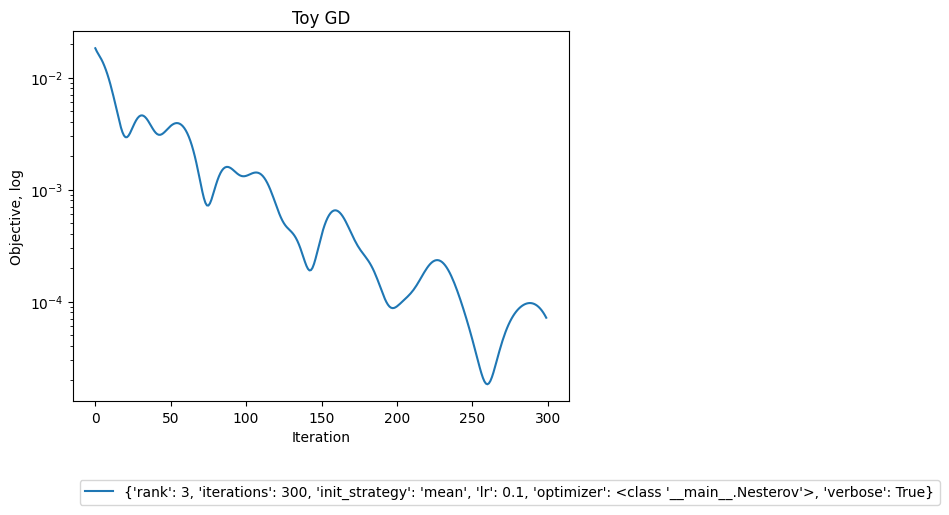

In [311]:
plot_log_dicts(gd_toy_res[-1], "Toy GD")

100%|██████████| 100/100 [05:49<00:00,  3.50s/it, Objective=0.00297]


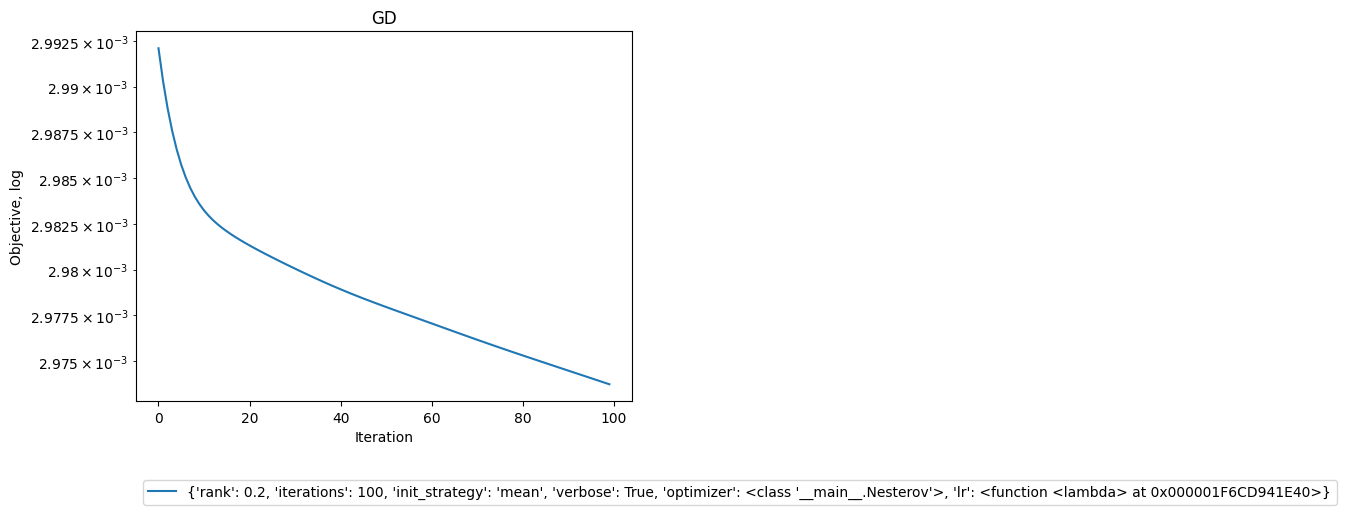

(array([[5.        , 3.16674484, 3.00542245, ..., 3.67391249, 3.92859947,
         3.82217565],
        [4.21234416, 3.29021238, 3.12391721, ..., 3.65050365, 3.94841787,
         3.87748396],
        [4.13111159, 3.21749931, 3.08379015, ..., 3.65913014, 3.93224455,
         3.84771647],
        ...,
        [4.17316258, 3.2060787 , 3.02911412, ..., 3.63495542, 3.94907791,
         3.8508041 ],
        [4.20479481, 3.10658871, 2.99262553, ..., 3.66087398, 3.93627775,
         3.87570072],
        [3.        , 3.28087886, 2.99823719, ..., 3.63390483, 3.91200488,
         3.91522264]]),
 0.9553477400010786,
 {'rank': 0.2,
  'iterations': 100,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Nesterov,
  'lr': <function __main__.<lambda>(k)>})

In [342]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    block_gd,
    lambda sol: rmse_score(real_matrix_full, sol, real_test_mask),
    {
        "rank": [0.2],
        "iterations": 100,
        "init_strategy": ["mean"],
        "verbose": True,
        "optimizer": Nesterov,
        # "lr": lambda k: 20/np.sqrt((k+1))
        "lr": lambda k: 1e-1 / np.sqrt((k + 1)),
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [344]:
save_solution(gd_res[0], decimals=5, prefix="gd")

## A1. SVD

In [ ]:
def impute(
    matrix: np.ndarray,
    mask: np.ndarray,
    strategy: Literal["mean", "most_frequent", "median", "random"],
) -> np.ndarray:
    if strategy in ["mean", "most_frequent", "median"]:
        return SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(matrix)

    new_matrix = matrix.copy()
    new_matrix[~mask] = np.random.uniform(low=1, high=5, size=np.sum(~mask))
    return new_matrix


def svd_based(
    initial_matrix: np.ndarray,
    mask: np.ndarray,
    rank: int | float,
    iterations: int,
    imputing_strategy: Literal["mean", "most_frequent", "median", "random"] = "mean",
    randomized_svd: bool = False,
    verbose: bool = True,
    diff_norm_stopping_criterion: Optional[float] = None,
    seed: int = 420,
) -> tuple[np.ndarray, dict]:
    np.random.seed(seed)

    # Initial imputing
    matrix = impute(initial_matrix, mask, strategy=imputing_strategy)

    r = rank
    if isinstance(rank, float):
        r = int(min(matrix.shape) * rank)

    log_dict = {
        "objective": [],
    }

    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for _ in loop:
            old_matrix = matrix[~mask].copy()

            if randomized_svd:
                u, s, vt = sklearn.utils.extmath.randomized_svd(
                    matrix, n_components=r, random_state=seed
                )
                s = np.diag(s)

            else:
                u, s, vt = np.linalg.svd(matrix, full_matrices=False)
                s = np.diag(s[:r])
                u = u[:, :r]
                vt = vt[:r, :]

            matrix = u @ s @ vt

            # Keep known values
            matrix[mask] = initial_matrix[mask]

            # log
            diff_norm = np.linalg.norm(matrix[~mask] - old_matrix)
            log_dict["objective"].append(diff_norm)
            if verbose:
                loop.set_postfix({"Difference norm": diff_norm})

            if (
                diff_norm_stopping_criterion is not None
                and diff_norm <= diff_norm_stopping_criterion
            ):
                break

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix, log_dict

In [ ]:
svd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    svd_based,
    lambda sol: rmse_score(toy_matrix_full, sol, toy_test_mask),
    {
        "rank": [0.2, 0.3, 0.5],
        "iterations": 25,
        "imputing_strategy": ["mean", "most_frequent", "median", "random"],
        "randomized_svd": [True, False],
        "verbose": False,
    },
)

svd_toy_res[:-1]

(array([[2.        , 3.        , 2.        , 2.92431594, 2.68232072],
        [0.45829577, 2.        , 3.07384344, 4.        , 1.34197273],
        [3.        , 4.46710247, 3.        , 4.37030923, 4.        ],
        [1.55571574, 3.        , 2.91388923, 4.        , 2.45737367],
        [1.07604102, 2.61790234, 3.09133014, 4.13588594, 2.        ],
        [1.        , 2.49527507, 3.        , 4.        , 1.89301043]]),
 1.22157424565747,
 {'rank': 0.5,
  'iterations': 25,
  'imputing_strategy': 'most_frequent',
  'randomized_svd': False,
  'verbose': False})

In [ ]:
plot_log_dicts(svd_toy_res[-1], "Toy SVD")

In [ ]:
svd_res = choose_best(
    real_matrix,
    real_mask,
    svd_based,
    lambda sol: rmse_score(real_matrix_full, sol, real_test_mask),
    {
        "rank": [1],
        "iterations": 200,
        "imputing_strategy": "random",
        "randomized_svd": True,
        "verbose": True,
    },
)

svd_res[:-1]

100%|██████████| 200/200 [03:45<00:00,  1.13s/it, Difference norm=3.65] 


(array([[5.        , 3.38652131, 3.24441599, ..., 3.69182739, 3.84242649,
         4.04154983],
        [4.03643502, 3.1162232 , 2.98546013, ..., 3.39716101, 3.53573991,
         3.71897005],
        [4.15777447, 3.20990011, 3.07520617, ..., 3.49928321, 3.64202794,
         3.83076616],
        ...,
        [3.86696185, 2.98538591, 2.86011304, ..., 3.2545283 , 3.38728886,
         3.56282592],
        [4.00175327, 3.08944806, 2.95980853, ..., 3.36797201, 3.50536022,
         3.68701601],
        [3.        , 2.9757912 , 2.85092094, ..., 3.2440686 , 3.37640248,
         3.55137538]]),
 2.646701411137743,
 {'rank': 1,
  'iterations': 200,
  'imputing_strategy': 'random',
  'randomized_svd': True,
  'verbose': True})

In [ ]:
plot_log_dicts(svd_res[-1], "SVD")

In [ ]:
save_solution(svd_res[0], decimals=5)